# ANN Model for Crypto Price Prediction

**Target**: Predicting whether the crypto price will be higher in 5 days than it is today  
**Method**: Artificial Neural Network (ANN) - Feedforward Neural Network with TensorFlow/Keras

## What is ANN?
- **Feedforward architecture**: Information flows in one direction (input → hidden layers → output)
- **No temporal awareness**: Treats each data point independently
- **Relies on feature engineering**: Uses all 68 engineered features (technical indicators, lags, etc.)
- **Simplest baseline**: Fastest training, smallest parameter count (~17K parameters)
- **No memory**: Cannot capture sequential patterns without manual lag features

In [17]:
# standart libraries
import pandas as pd
import numpy as np
import random
import datetime
import time
from pathlib import Path 

# project specific libraries
import tensorflow as tf

# random seeds for reproducibility e.g. initialisation of weights in NN
SEED = 101 #usually 42 but for uniformity 101
tf.random.set_seed(SEED) #weight initialization, dropout masks, batch shuffling
np.random.seed(SEED) #array operations, train_test_split, data transformations
random.seed(SEED) #random(), shuffle(), choice()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
# load data
df_ann = pd.read_csv("/Users/ina/Documents/spicedAcademy/crypto_price_prediction/data/final_data/20251115_dataset_crp.csv")

In [19]:
#quick & last check for date format
df_ann['date'].dtype
#if lost df_ann['date'] = pd.to_datetime(df_ann['date'], format="ISO8601", utc=True)

dtype('O')

In [20]:
# Train-Validation-Test Split (70%-15%-15% temporal split)
split_date_train = "2024-07-01"  # Training until this date
split_date_val = "2024-10-01"    # Validation from here
split_date_test = "2025-01-01"   # Testing from here

#parameter
x_cols_to_drop = ['ticker', 'date', 'future_5_close_higher_than_today', 'future_10_close_higher_than_today',
"future_5_close_lower_than_today", "future_10_close_lower_than_today", "higher_close_today_vs_future_5_close", 
"higher_close_today_vs_future_10_close", "lower_close_today_vs_future_5_close", "lower_close_today_vs_future_10_close"]

df_train = df_ann[df_ann['date'] < split_date_train].copy()
df_val = df_ann[(df_ann['date'] >= split_date_train) & (df_ann['date'] < split_date_val)].copy()
df_test = df_ann[df_ann['date'] >= split_date_test].copy()

print(f"\nTraining set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")
print(f"Train up to date: {df_train['date'].max()}")
print(f"Validation from date: {df_val['date'].min()} to {df_val['date'].max()}")
print(f"Test from date: {df_test['date'].min()}")


Training set: 142034 samples
Validation set: 9543 samples
Test set: 39328 samples
Train up to date: 2024-06-30 00:00:00+00:00
Validation from date: 2024-07-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Test from date: 2025-01-01 00:00:00+00:00


In [21]:
# Prepare features and targets for all three sets
X_train = df_train.drop(x_cols_to_drop, axis='columns')
y_train = df_train["future_5_close_higher_than_today"].to_numpy()

X_val = df_val.drop(x_cols_to_drop, axis='columns')
y_val = df_val["future_5_close_higher_than_today"].to_numpy()

X_test = df_test.drop(x_cols_to_drop, axis='columns')
y_test = df_test["future_5_close_higher_than_today"].to_numpy()

# Scaling - separate scalers for X and y
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler (uses mean and standard deviation)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data ONLY (avoid leakage)
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Transform validation data using training scalers
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

# Transform test data using training scalers
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

In [22]:
# model architecture - parameter/hyperparameter

layer_1_nodes = 128
layer_1_dropout = 0.2

layer_2_nodes = 64
layer_2_dropout = 0.2

use_layer_2 = True

learning_rate = 0.0001
L2_regularization = 0.0001

In [23]:
# Model Architecture
if use_layer_2:
    ann_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),

        # l1
        tf.keras.layers.Dense(
            layer_1_nodes,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
            name='hidden_layer_1'
        ),
        tf.keras.layers.Dropout(layer_1_dropout, name='dropout_1'),

        # l2
        tf.keras.layers.Dense(
            layer_2_nodes,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
            name='hidden_layer_2'
        ),
        tf.keras.layers.Dropout(layer_2_dropout, name='dropout_2'),

        # Output Layer
        tf.keras.layers.Dense(1, activation='linear', name='output')
    ])
else:
    ann_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(
            layer_1_nodes,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(L2_regularization)
        ),
        tf.keras.layers.Dropout(layer_1_dropout),
        tf.keras.layers.Dense(1, activation='linear')
    ])

#model summary
print("ANN architecture:")
ann_model.summary()

ANN architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# compile model
ann_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mae',
    metrics=['mae', 'mse']
)

In [25]:
# train model

# Training parameters
epochs = 100
batch_size = 512
patience = 10

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

history = ann_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),  # Use validation set, NOT test set!
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8550 - mae: 0.8378 - mse: 1.2335 - val_loss: 0.7532 - val_mae: 0.7363 - val_mse: 0.9366
Epoch 2/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7968 - mae: 0.7799 - mse: 1.1021 - val_loss: 0.7571 - val_mae: 0.7404 - val_mse: 0.9508
Epoch 3/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7752 - mae: 0.7585 - mse: 1.0566 - val_loss: 0.7578 - val_mae: 0.7413 - val_mse: 0.9516
Epoch 4/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7651 - mae: 0.7487 - mse: 1.0352 - val_loss: 0.7568 - val_mae: 0.7406 - val_mse: 0.9498
Epoch 5/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7592 - mae: 0.7430 - mse: 1.0245 - val_loss: 0.7576 - val_mae: 0.7416 - val_mse: 0.9533
Epoch 6/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7559 - mae: 0.7400 - mse: 1.0169 - val_loss: 0.7589 - val_mae: 0.7431 - val_mse: 0.9551
Epoch 7/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7521 - mae: 0.7363 - mse: 1.009

In [26]:
# training set metrics from the last epoch

mae_train = history.history['mae'][-1] #last epoch
mse_train = history.history['mse'][-1]
print("Train Set Performance:")
print(f"   mae:  {mae_train:.4f}")
print(f"   mse:  {mse_train:.4f}")


# validation set metrics from the last epoch
val_mae = history.history['val_mae'][-1]
val_mse = history.history['val_mse'][-1]
print("\n Validation Set Performance:")
print(f"   mae:  {val_mae:.4f}")
print(f"   mse:  {val_mse:.4f}")

Train Set Performance:
   mae:  0.7296
   mse:  1.0007

 Validation Set Performance:
   mae:  0.7437
   mse:  0.9562


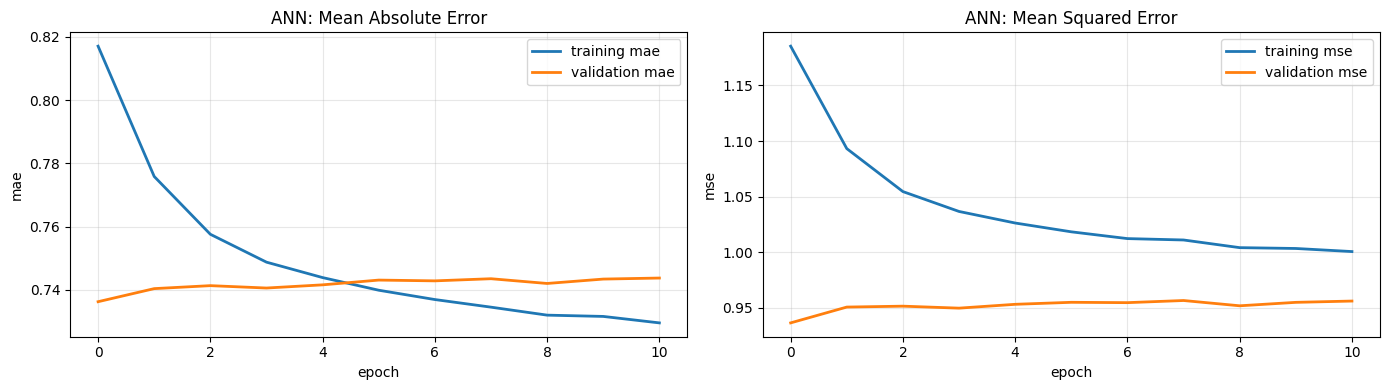

In [27]:
# visualize training history - ANN

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# mae
axes[0].plot(history.history['mae'], label='training mae', linewidth=2)
axes[0].plot(history.history['val_mae'], label='validation mae', linewidth=2)
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('mae')
axes[0].set_title('ANN: Mean Absolute Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#mse
axes[1].plot(history.history['mse'], label='training mse', linewidth=2)
axes[1].plot(history.history['val_mse'], label='validation mse', linewidth=2)
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('mse')
axes[1].set_title('ANN: Mean Squared Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_scaled = ann_model.predict(X_test_scaled)

# Calculate metrics on scaled data
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)

print("Test Set Performance on Scaled Data:")
print(f"   mae:  {mae:.4f}")
print(f"   mse:  {mse:.4f}")

1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
Test Set Performance on Scaled Data:
   mae:  0.7396
   mse:  0.9690


In [29]:
# INVERSE TRANSFORM back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Calculate metrics on ORIGINAL scale
mae = mean_absolute_error(y_test, y_pred_original)
mse = mean_squared_error(y_test, y_pred_original)

print("Test Set Performance on Original Scale:")
print(f"   MAE:  {mae:.4f}")
print(f"   MSE:  {mse:.4f}")

Test Set Performance on Original Scale:
   MAE:  8.4002
   MSE:  125.0039


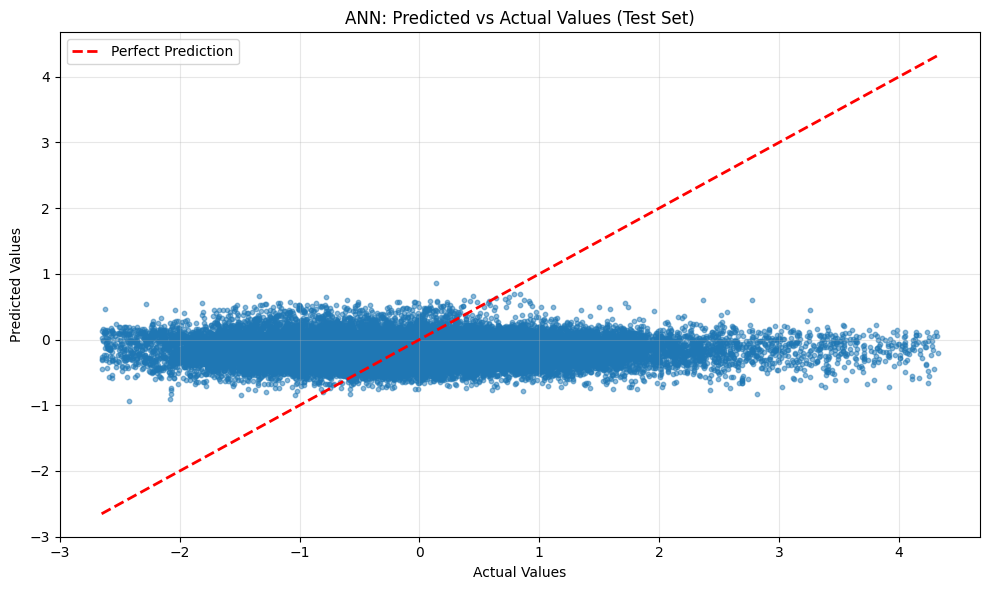

In [30]:
# visualize final prediction - predicted vs. actual (ANN)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_scaled, y_pred_scaled, alpha=0.5, s=10)
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('ANN: Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

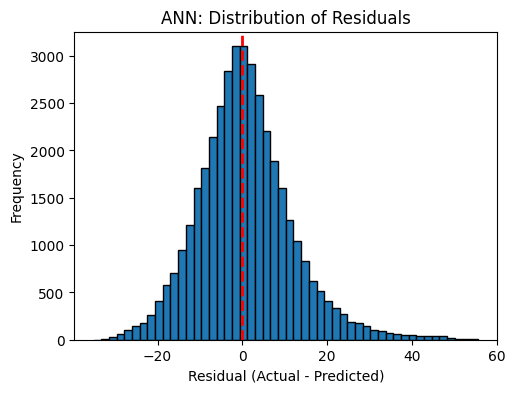

In [31]:
# visualize final prediction - residuals (ANN)

residuals = y_test - y_pred_original.flatten()
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('ANN: Distribution of Residuals')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)

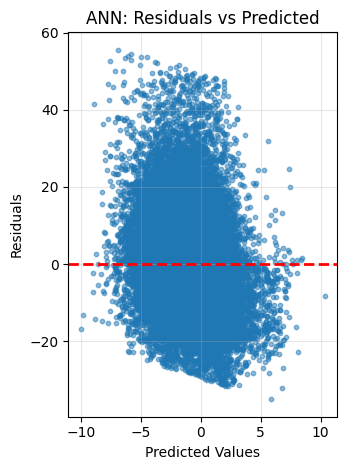

In [32]:
# visualize final prediction - residuals vs. predicted (ANN)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_original, residuals, alpha=0.5, s=10)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('ANN: Residuals vs Predicted')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()